In [39]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# -------- Encoder Block --------
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


# -------- U-Net Model --------
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.down1 = DoubleConv(1, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool(c1)

        c2 = self.down2(p1)
        p2 = self.pool(c2)

        c3 = self.down3(p2)
        p3 = self.pool(c3)

        c4 = self.down4(p3)
        p4 = self.pool(c4)

        bn = self.bottleneck(p4)

        u4 = self.up4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        c4 = self.conv4(u4)

        u3 = self.up3(c4)
        u3 = torch.cat([u3, c3], dim=1)
        c3 = self.conv3(u3)

        u2 = self.up2(c3)
        u2 = torch.cat([u2, c2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, c1], dim=1)
        c1 = self.conv1(u1)

        return torch.sigmoid(self.output(c1))


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet().to(device)
model.load_state_dict(torch.load("/kaggle/input/segmentation-val/unet_fetal_head_seg.pth", map_location=device))
model.eval()

print("Model loaded ✔️")

Model loaded ✔️


In [42]:
def fill_mask(mask):
    m = (mask.squeeze().detach().cpu().numpy() * 255).astype(np.uint8)

    cnts,_ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filled = np.zeros_like(m)

    if len(cnts) > 0:
        cv2.drawContours(filled, cnts, -1, 255, -1)

    return torch.tensor(filled/255.0).unsqueeze(0).float()

In [43]:
class FetalValDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.files = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx]
        img = Image.open(os.path.join(self.img_dir, name)).convert("L")
        mask = Image.open(os.path.join(self.mask_dir, name.replace(".png","_Annotation.png"))).convert("L")

        img = TF.resize(img, (512,512))
        mask = TF.resize(mask,(512,512), interpolation=TF.InterpolationMode.NEAREST)

        img  = TF.to_tensor(img)
        img = (img - img.mean()) / (img.std() + 1e-6)

        mask = (TF.to_tensor(mask) > 0.5).float()

        return img, mask

val_dataset = FetalValDataset("/kaggle/input/segmentation/images-20251230T160417Z-3-001/images", "/kaggle/input/segmentation/masks-20251230T160416Z-3-001/masks")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

print("Val samples:", len(val_dataset))

Val samples: 622


In [49]:
def dice_score(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum()
    return (2*inter + eps) / (pred.sum() + target.sum() + eps)

limit = int(len(val_loader) * 0.15)

dice_list = []

with torch.no_grad():
    for i, (x, y) in enumerate(val_loader):
        if i >= limit:
            break

        x = x.to(device); y = y.to(device)

        out = model(x)
        filled = torch.stack([fill_mask(m) for m in y]).to(device)

        dice_list.append(dice_score(out, filled).item())

print(f"\nMean Dice (first 15%): {np.mean(dice_list):.4f}")
print(f"Std Dev Dice: {np.std(dice_list):.4f}")


Mean Dice (first 15%): 0.9218
Std Dev Dice: 0.0494


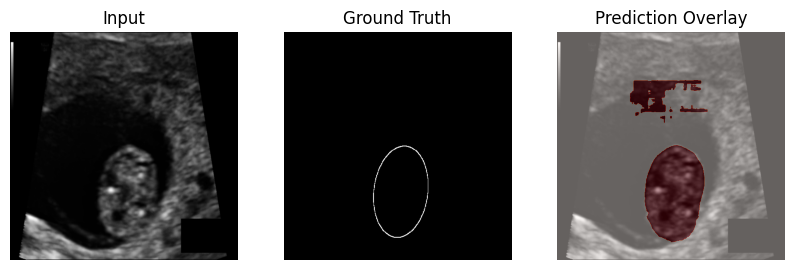

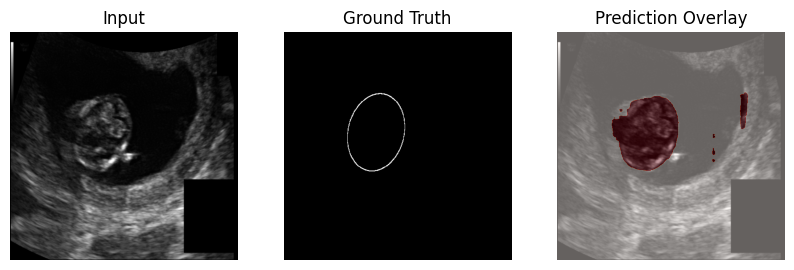

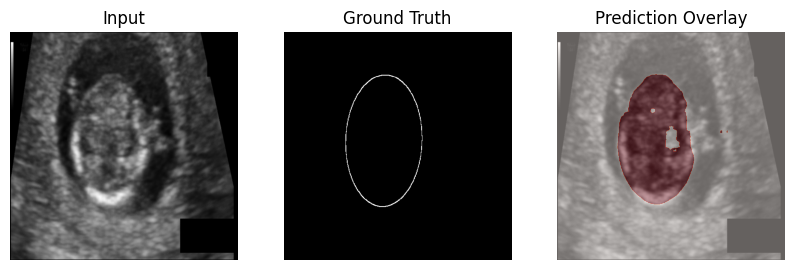

In [50]:
def show_sample(i):
    img, mask = val_dataset[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).cpu().squeeze()

    fig, ax = plt.subplots(1,3, figsize=(10,4))
    ax[0].imshow(img.squeeze(), cmap="gray"); ax[0].set_title("Input")
    ax[1].imshow(mask.squeeze(), cmap="gray"); ax[1].set_title("Ground Truth")
    ax[2].imshow(img.squeeze(), cmap="gray")
    ax[2].imshow(pred>0.5, alpha=0.4, cmap="Reds")
    ax[2].set_title("Prediction Overlay")
    for a in ax: a.axis("off")
    plt.show()

show_sample(0)
show_sample(5)
show_sample(10)

In [51]:
x, y = val_dataset[0]
with torch.no_grad():
    pred = model(x.unsqueeze(0).to(device)).cpu()

print("Pred shape:", pred.shape)
print("Pred min/max:", pred.min().item(), pred.max().item())

Pred shape: torch.Size([1, 1, 512, 512])
Pred min/max: 0.0034976385068148375 0.9995445609092712


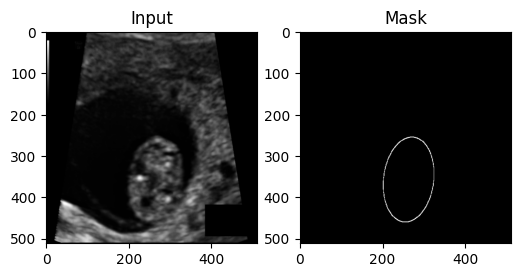

In [52]:
img, mask = val_dataset[0]

plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(img.squeeze(), cmap="gray"); plt.title("Input")
plt.subplot(1,2,2); plt.imshow(mask.squeeze(), cmap="gray"); plt.title("Mask")
plt.show()